In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def findLeft(pts, shape):
  mi, mipt = shape[0], None
  for pt in pts:
    if pt[0] < mi:
      mi = pt[0]
      mipt = pt
  return mipt

def findRight(pts, shape):
  ma, mapt = 0, None
  for pt in pts:
    if pt[0] > ma:
      ma = pt[0]
      mapt = pt
  return mapt

def findTop(pts, shape):
  mi, mipt = shape[1], None
  for pt in pts:
    print(pt, mi)
    if pt[1] < mi:
      mi = pt[1]
      mipt = pt
  return mipt

def findBottom(pts, shape):
  ma, mapt = 0, None
  for pt in pts:
    if pt[1] > ma:
      ma = pt[1]
      mapt = pt
  return mapt

In [4]:
def findExtremes(pts, shape):
  left, right, top, bottom = findLeft(pts, shape), findRight(pts, shape), findTop(pts, shape), findBottom(pts, shape)
  return [left, right, top, bottom]

In [5]:
def isFloor(pts, shape):
  for pt in pts:
    if pt[1] < shape[1] * 0.3:
      return False
  return True

In [6]:
#---------------To arrange the points clockwise---------------
def order_points(pts):
    if len(pts) == 4:
        pts = np.array(pts)
        rect = np.zeros((4, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
    else:
        pts = np.array(pts)
        rect = np.zeros((2, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
    return rect

In [7]:
def isCloseToEdge(pt, shape):
  if pt[0] > 50 and pt[0] < shape[0] - 50:
    return True
  return False

In [8]:
def isLeft(pts, shape):
  for pt in pts:
    if pt[0] > 0.7 * shape[0]:
      return False
  return True

In [10]:
def get_mask_imgs(img_path):
    mask_imgs = []
    for img in os.listdir(img_path):
        if img.split('.')[-1] == 'png':
            mask_imgs.append(img_path+"/"+img)
    return mask_imgs

def read_imgs(mask_path):
    mask_imgs = get_mask_imgs(mask_path)
    # print(mask_imgs)
    masks = []
    for img in mask_imgs:
        mask = cv2.imread(img, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        ret, bw_img = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        # print(bw_img.shape)
        # plt.imshow(mask)
        masks.append(bw_img)
    return masks

def find_rectangle_manually(given_masks):
    rectangles = []
    for mask in given_masks:
        mask = np.array(mask)
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        # print(*gray_mask[400])
        row_ind = []
        for i in range(gray_mask.shape[0]):
            inds = np.where(gray_mask[i] == 255)[0]
            if inds.size != 0:
                row_ind.append(i)
        top, bottom = row_ind[0], row_ind[-1]

        col_ind = []
        for i in range(gray_mask.shape[1]):
            inds = np.where(gray_mask[:, i] == 255)[0]
            if inds.size != 0:
                col_ind.append(i)
        left, right = col_ind[0], col_ind[-1]

        rectangles.append([
            [left, top],
            [right, top],
            [right, bottom],
            [left, bottom]
        ])
    return rectangles


from rdp import rdp
def find_peak_points(mask):
    msk = mask.copy()
    edge=cv2.Canny(msk, 30, 20)
    contours, hierarchy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ## separating the mask outline from all other unwanted contours
    outline = []
    for i in contours:
        # print(len(i))
        if i.shape[0] > 100:
            outline.extend(i)
    # print(outline.shape)

    msk = cv2.drawContours(msk, outline, -1, (0, 255, 0), 3)
    ## finding the peak points using the Douglas-Peucker algorithm
    pp=rdp(outline, epsilon=25)
    for i in pp:
        msk = cv2.circle(msk, i[0], 5, (0, 0, 255), -1)
    # plt.imshow(msk)
    return np.array(pp)

def pick_peak_pts(mask, pp):
    rect = find_rectangle_manually([mask])[0]
    new_rect = []
    for p1 in rect:
        pt_dist = []
        for p2 in pp:
            dist = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
            pt_dist = np.append(pt_dist, dist)
        # print(pt_dist)
        new_rect.append(pp[np.argmin(pt_dist)])

    tmp = mask.copy()
    for i in pp:
        tmp = cv2.circle(tmp, i, 10, (0, 0, 255), -1)
    for i in range(4):
        tmp = cv2.circle(tmp, rect[i], 8, (255, 0, 0), -1)
        tmp = cv2.circle(tmp, new_rect[i], 8, (0, 255, 0), -1)
    # plt.imshow(tmp)

    return rect, np.array(new_rect)

In [11]:
USER_IMG = 'img3'

all_mask_paths = "../inputs/masks/{}".format(USER_IMG)
all_masks = read_imgs(all_mask_paths)
print(len(all_masks))


3


In [12]:
peak_pts, new_rectangles, rectangles, peak_points_for_masks = [], [], [], []
for mask in all_masks:
    peak_pts = find_peak_points(mask).reshape([-1, 2])
    peak_points_for_masks.append(peak_pts)
    print("reduced pp from masks:",len((peak_pts)))

    rect, new_rect = pick_peak_pts(mask, peak_pts)
    rectangles.append(rect)
    new_rectangles.append(new_rect)


extremes = []
for pts in peak_points_for_masks:
  extremes.append(findExtremes(pts, all_masks[0].shape))
for _ in extremes:
  print(_)
  print('--------------------------------------------------------------')

reduced pp from masks: 8
reduced pp from masks: 46
reduced pp from masks: 27
[630 814] 1600
[323 971] 814
[ 330 1079] 814
[ 139 1189] 814
[ 173 1197] 814
[1456 1195] 814
[1472 1016] 814
[631 814] 814
[1316  205] 1600
[915 249] 205
[915 634] 205
[1270  684] 205
[1314  674] 205
[1347  207] 205
[955  81] 205
[606 143] 81
[612 416] 81
[673 418] 81
[717 365] 81
[834 366] 81
[715 445] 81
[612 458] 81
[627 782] 81
[1484  979] 81
[1498  873] 81
[1406  834] 81
[1506  830] 81
[1584  168] 81
[847 217] 81
[1585  169] 81
[1506  830] 81
[1406  834] 81
[1499  875] 81
[1479  979] 81
[629 784] 81
[612 459] 81
[716 445] 81
[834 365] 81
[717 365] 81
[672 418] 81
[614 417] 81
[603 146] 81
[965  81] 81
[992 195] 81
[956  81] 81
[1571    0] 81
[1336   20] 0
[1332  154] 0
[1582  152] 0
[1599   66] 0
[1582  152] 0
[1332  153] 0
[1336   20] 0
[1571    1] 0
[583 450] 1600
[581 617] 450
[264 708] 450
[316 935] 450
[626 775] 450
[612 459] 450
[329 221] 450
[565 263] 221
[596 417] 221
[609 258] 221
[208 219] 221
[

In [14]:
finalTransformableCoordinates = []

for i in range(len(peak_points_for_masks)):
  if isFloor(new_rectangles[i], all_masks[0].shape):
    vertices = order_points(new_rectangles[i])
    if (isCloseToEdge(vertices[0], all_masks[0].shape) and isCloseToEdge(vertices[1], all_masks[0].shape)):
      print('1111')
      x1, y1 = extremes[i][2]
      x2, y2 = vertices[0]
      x3, y3 = vertices[1]
      y = 2 * all_masks[0].shape[1] - y1
      x2d = int(((all_masks[0].shape[1] - y1) / (y2 - y1)) * (x2 - x1) + x1)
      x3d = int(((all_masks[0].shape[1] - y1) / (y3 - y1)) * (x3 - x1) + x1)
      x = x3d - x2d - x1 + x2d
      finalTransformableCoordinates.append([[x1,y1], [x3d,all_masks[0].shape[1]], [x,y], [x2d,all_masks[0].shape[1]]])
    elif (isCloseToEdge(vertices[0], all_masks[0].shape)):
      print('2222')
      x1, y1 = extremes[i][2]
      x2, y2 = vertices[0]
      x3, y3 = vertices[1]
      y = 2 * all_masks[0].shape[1] - y1
      x = all_masks[0].shape[0] - x1
      x2d = int(((all_masks[0].shape[1] - y1) / (y2 - y1)) * (x2 - x1) + x1)
      x3d = int(((all_masks[0].shape[1] - y1) / (y3 - y1)) * (x3 - x1) + x1)
      x = x3d - x2d - x1 + x2d
      finalTransformableCoordinates.append([[x1,y1], [x3d,all_masks[0].shape[1]], [x,y], [x2d,all_masks[0].shape[1]]])
    elif (vertices[0][1] > all_masks[0].shape[1] - 50 and isCloseToEdge(vertices[1], all_masks[0].shape)):
      print('3333')
      x1, y1 = extremes[i][2]
      x2, y2 = vertices[0]
      x3, y3 = vertices[1]
      y = 2 * all_masks[0].shape[1] - y1
      x = all_masks[0].shape[0] - x1
      x2d = int(((all_masks[0].shape[1] - y1) / (y2 - y1)) * (x2 - x1) + x1)
      x3d = int(((all_masks[0].shape[1] - y1) / (y3 - y1)) * (x3 - x1) + x1)
      x = x3d - x2d - x1 + x2d
      finalTransformableCoordinates.append([[x1,y1], [x3d,all_masks[0].shape[1]], [x,y], [x2d,all_masks[0].shape[1]]])
    else:
      x1, y1 = extremes[i][2]
      if y1 == vertices[0][1] or y1 == vertices[1][1]:
        finalTransformableCoordinates.append(vertices)
      else:
        print('4444')
        print(vertices)
        print(extremes[i])
        x2, y2 = vertices[0]
        x3, y3 = vertices[1]
        y = 2 * all_masks[0].shape[1] - y1
        x = all_masks[0].shape[0] - x1
        x2d = int(((all_masks[0].shape[1] - y1) / (y2 - y1)) * (x2 - x1) + x1)
        x3d = int(((all_masks[0].shape[1] - y1) / (y3 - y1)) * (x3 - x1) + x1)
        x = x3d - x2d - x1 + x2d
        finalTransformableCoordinates.append([[x1,y1], [x3d,all_masks[0].shape[1]], [x,y], [x2d,all_masks[0].shape[1]]])
  else:
    vertices = order_points(new_rectangles[i])
    if isLeft(new_rectangles[i], all_masks[0].shape):
      # print(vertices)
      # print(extremes)
      x1, y1 = extremes[i][2]
      x2, y2 = vertices[1]
      if y1 == y2:
        x1, y1 = vertices[0]
      x = extremes[i][0][0]
      y = int((((x-x1)/(x2-x1))*(y2-y1)) + y1)
      x3, y3 = extremes[i][3]
      x4, y4 = vertices[2]
      if y3 == y4:
        x3, y3 = vertices[3]
      xd = extremes[i][0][0]
      yd = int((((xd-x3)/(x4-x3))*(y4-y3)) + y3)
      finalTransformableCoordinates.append([[x,y], vertices[1], vertices[2], [xd,yd]])
    else:
      # print(vertices)
      # print(extremes[i])
      x1, y1 = extremes[i][2]
      x2, y2 = vertices[0]
      if y1 == y2:
        x1, y1 = vertices[1]
      x = extremes[i][1][0]
      y = int((((x-x1)/(x2-x1))*(y2-y1)) + y1)
      x3, y3 = extremes[i][3]
      x4, y4 = vertices[3]
      if y3 == y4:
        x3, y3 = vertices[2]
      xd = extremes[i][1][0]
      yd = int((((xd-x3)/(x4-x3))*(y4-y3)) + y3)
      # print(i, y, yd)
      finalTransformableCoordinates.append([vertices[0], [x,y], [xd,yd], vertices[3]])

for boxes in finalTransformableCoordinates:
  print(boxes)
  print('--------------------------------------------------------------------------------------------------------------------')

2222
[[630, 814], [3906, 1600], [3276, 2386], [-906, 1600]]
--------------------------------------------------------------------------------------------------------------------
[array([606., 143.], dtype=float32), [1599, -4], [1599, 1005], array([629., 784.], dtype=float32)]
--------------------------------------------------------------------------------------------------------------------
[[0, -16], array([600., 143.], dtype=float32), array([626., 775.], dtype=float32), [0, 1098]]
--------------------------------------------------------------------------------------------------------------------


In [44]:
tmp = None

[  0 -16]
[600 143]
[626 775]
[   0 1098]


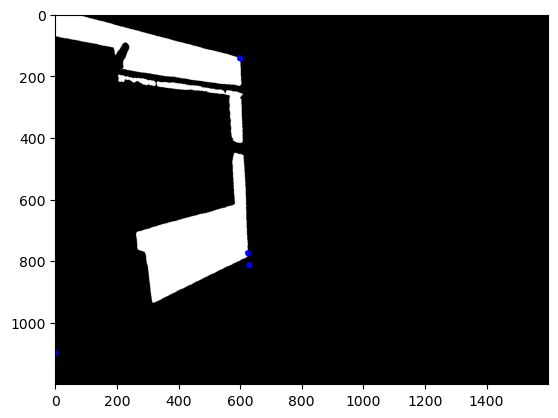

In [45]:
tmp = all_masks[2]
for i in np.array(finalTransformableCoordinates[2], dtype=int):
    print(i)
    tmp = cv2.circle(tmp, i, 10, (0, 0, 255), -1)
plt.imshow(tmp)